# **Preface**
**This project was inspired and referenced in [TensorFlow roBERTa - [0.705]](https://www.kaggle.com/code/cdeotte/tensorflow-roberta-0-705)**

# **Feeling about this project**

## **Vinh**
**Before to do get this course, i just a newbie in data science. Everything with me are new and i think i should do more for getting the information through the project.
It's so lucky for me to have a dedicated teacher and a good teammate. First of all, doing this NLP project is so hard for me nut Tam helped me and showed me a lot. Day by day, with the instructions and comments of teacher and other people. I can do it better and better.
Thank for helping me in this project.**


# **1/ About team**
|StuID  |        Name       |     Kaggle    |       Github      |
|-------|-------------------|---------------|-------------------|
|1752052|Dang Huu Phuoc Vinh|[V_Notebook](https://www.kaggle.com/danghuuphuocvinh)|[V_Github](https://github.com/DangHuuPhuocVinh/data_science_application)
|1753097|Le Nguyen Minh Tam |[T_Notebook](https://www.kaggle.com/minhtamlenguyen)|[T_Github](https://github.com/lnmtam1999)

## **1.1/ Link Github of team**

[Github](https://github.com/DangHuuPhuocVinh/data_science_application)


# **2/ About competition**

## **2.1/ Name of competition**
**[Tweet Sentiment Extraction](https://www.kaggle.com/competitions/tweet-sentiment-extraction) organized by [Kaggle](https://www.kaggle.com/)**

## **2.2/ Prize**
**15000 USD**

## **2.3/ Description**
  **E.g: "My ridiculous dog is amazing." [sentiment: positive]**

  **With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.**

  **In this competition we've extracted support phrases from [Figure Eight's Data for Everyone platform](https://appen.com/datasets-resource-center/). The dataset is titled Sentiment Analysis: Emotion in Text tweets with existing sentiment labels, used here under creative commons attribution 4.0. international licence. Your objective in this competition is to construct a model that can do the same - look at the labeled sentiment for a given tweet and figure out what word or phrase best supports it.**

## **2.4/ Input and Output**
- **Input: textID, text and sentiment**
- **Output: selected_text**

## **2.5/ Columns**
-  **textID - unique ID for each piece of text**
-  **text - the text of the tweet**
-  **sentiment - the general sentiment of the tweet**
-  **selected_text - [train only] the text that supports the tweet's sentiment**

## **2.6/ Meaningful**
- **After doing this project, we can have a dataset with the phrases that were selected for using at any other NLP project**
- **Can use for detecting some keywords that have sentiment** 

## **2.7/ Evaluation**
 ![img](https://user-images.githubusercontent.com/35680794/174698744-57b2f116-fbe4-4fb6-9216-2e83e0494dca.png)

# **3/ Model roBERTa for this project**

![img](https://images.viblo.asia/e8bfa0ba-dacd-4e6e-af7e-9c13370c2e3f.png)



![img](https://images.viblo.asia/bdb4660c-33bd-4b90-b36f-477593416302.png)

![img](https://images.viblo.asia/e89ac9ee-7ac9-4e8c-af6f-abe433f268ca.png)

![img](https://editor.analyticsvidhya.com/uploads/69307Screenshot%20(175).png)

![img](https://editor.analyticsvidhya.com/uploads/23540Screenshot%20(177).png)

# **4/ Developing the project**

## **4.1/ Import Libraries, Data and Tokenizer**

In [1]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob


### **4.1.1/ Tokenizer**
First of all, we use tokenizer to convert the word to array for the computer can understand.

In [2]:
MAX_LEN = 100
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


**MAX_LEN** = 96 then for each training row, RoBERTa receives 96 tokens. The reason to use **lowercase** and **add_prefix_space** because when spelling with RoBERTa :" helllo", "hello", " Hello", and "Hello" use the same " hello" token.

## **4.2/ Training data**


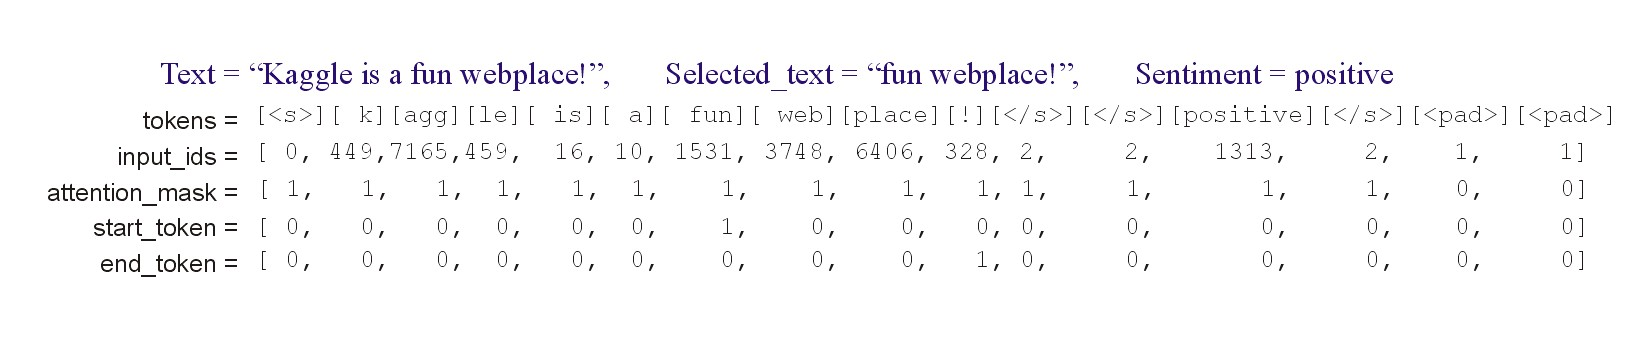

### **4.2.1/ Adjust the input**
In this stage we ready our data for the model, all the input will be change to numerical and training.

In [3]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

In [4]:
print("\n",input_ids)


 [[    0   939 12905 ...     1     1     1]
 [    0    98  3036 ...     1     1     1]
 [    0   127  3504 ...     1     1     1]
 ...
 [    0  1423   857 ...     1     1     1]
 [    0    53    24 ...     1     1     1]
 [    0    70    42 ...     1     1     1]]


In [5]:
print("\n",attention_mask)


 [[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [6]:
print("\n",offsets)


 [(0, 4), (4, 9), (9, 12), (12, 18), (18, 24), (24, 27), (27, 29), (29, 33), (33, 36), (36, 37), (37, 44), (44, 45), (45, 47), (47, 49), (49, 50), (50, 53), (53, 54), (54, 57), (57, 59)]


### **4.2.2/Visualizing the sentiment**

We will see which words have the negative sentiment

7781


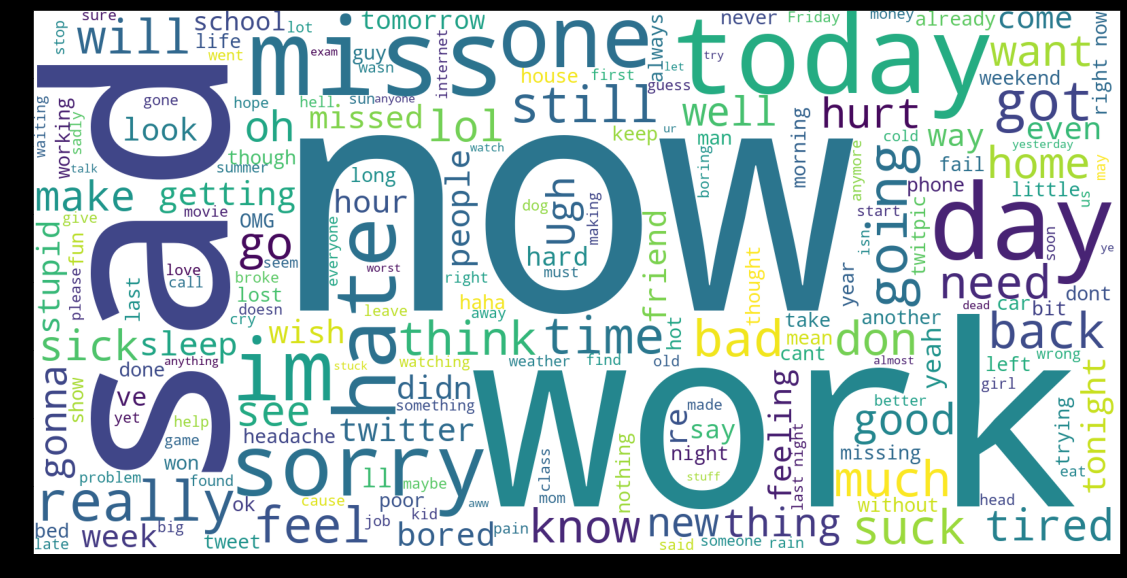

In [7]:
Negative = train[train['sentiment'] == ('negative')]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(Negative.text))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)
print(len(Negative))

We will see which words have the positive sentiment

7781


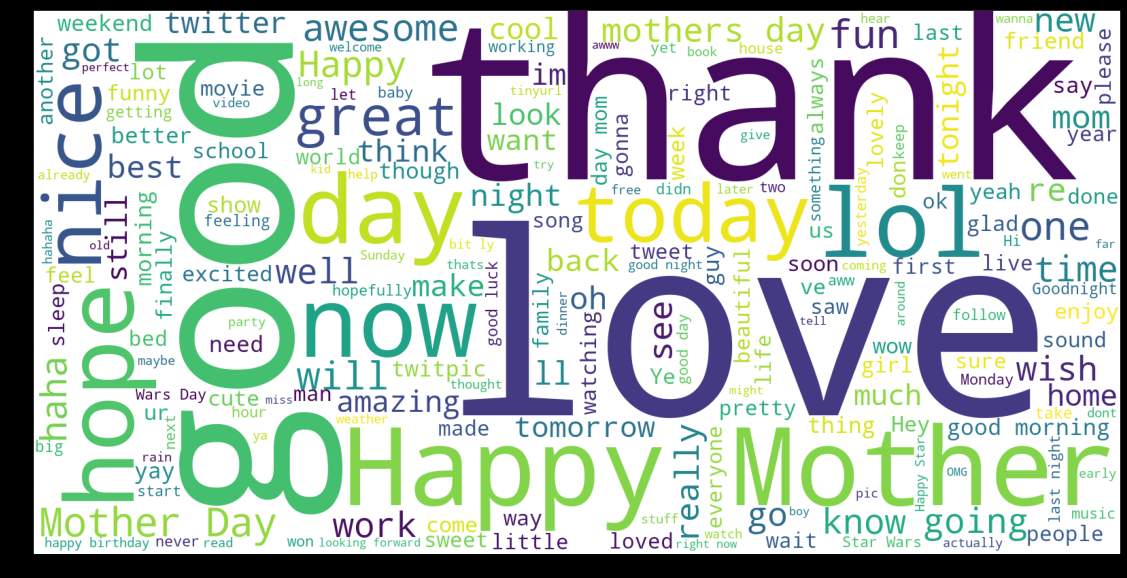

In [8]:
Positive = train[train['sentiment'] == ('positive')]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(Positive.text))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)
print(len(Negative))

We will see which words have the neutral sentiment

7781


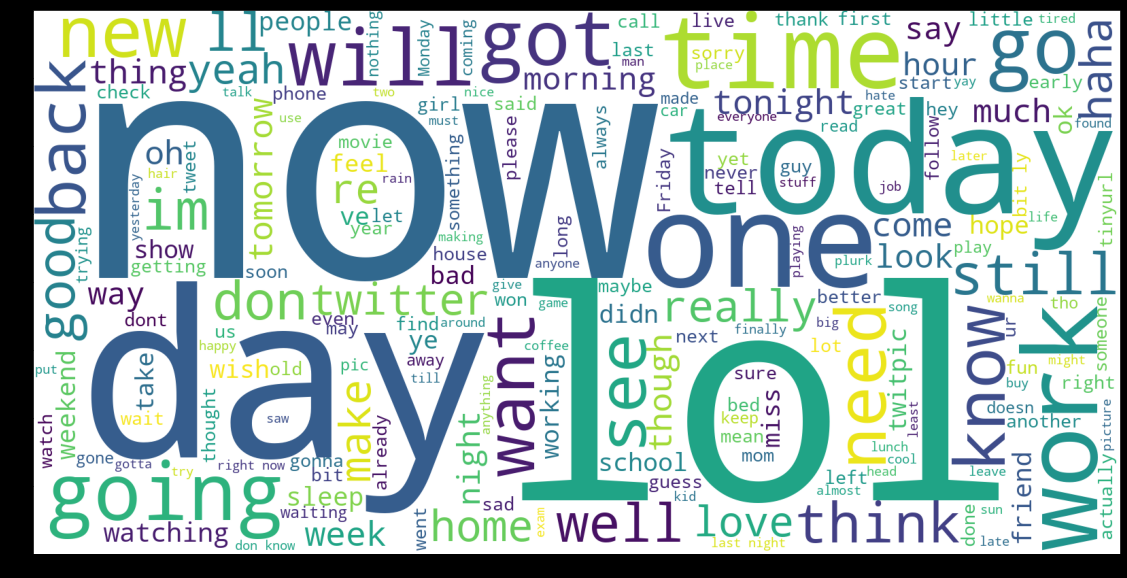

In [9]:
Neutral = train[train['sentiment'] == ('neutral')]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(Neutral.text))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)
print(len(Negative))

## **4.3/ Test Data**

We do the same as the Training stage.

In [10]:
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').fillna('')

ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

if the original text is [ i][ am][ having][ a][ great][ day]</s>[ positive]</s> with tokens 0,1,2,3,4,5,6,7,8,9,10 and the selected text is "great day", then the training has start index = 5 and end index = 6.

If our model also predicts a = 5 and b = 6 and we try to select the text from [ i][ am][ having][ a][ great][ day], the indices 5 and 6 will not return "great day". Instead we must use tokens[4:6] to get great day. We subtract 1 because the is now removed. And we add 1 to b because python indexing for list[3:5] does not return 5 it only returns 3, 4

### **4.3.1/Visualizing the sentiment**

We will see which words have the negative sentiment

1001


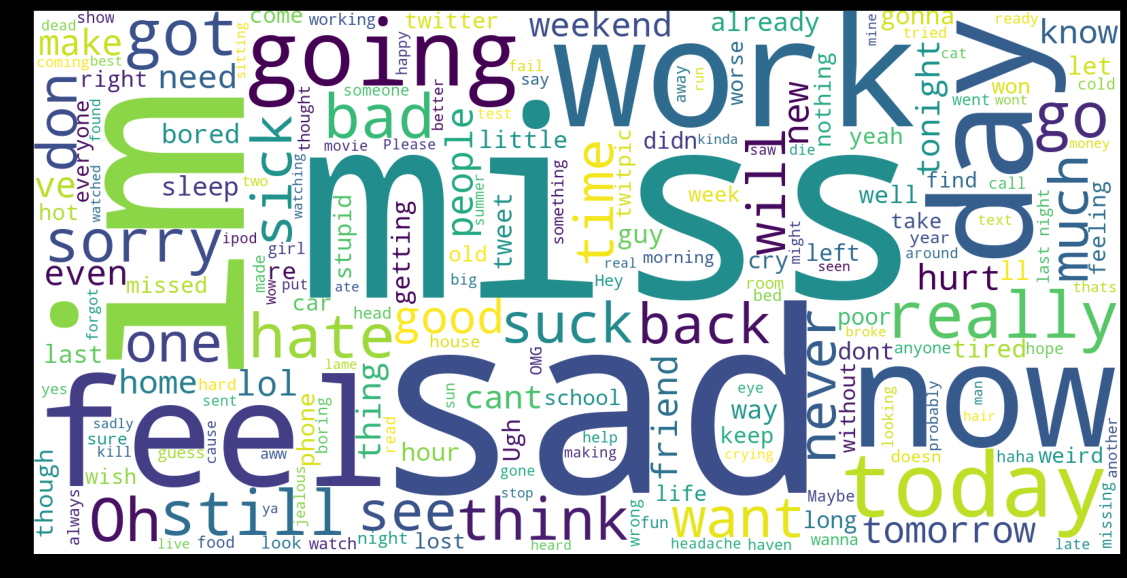

In [11]:
Negative = test[test['sentiment'] == ('negative')]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(Negative.text))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)
print(len(Negative))

We will see which words have the positive sentiment

1001


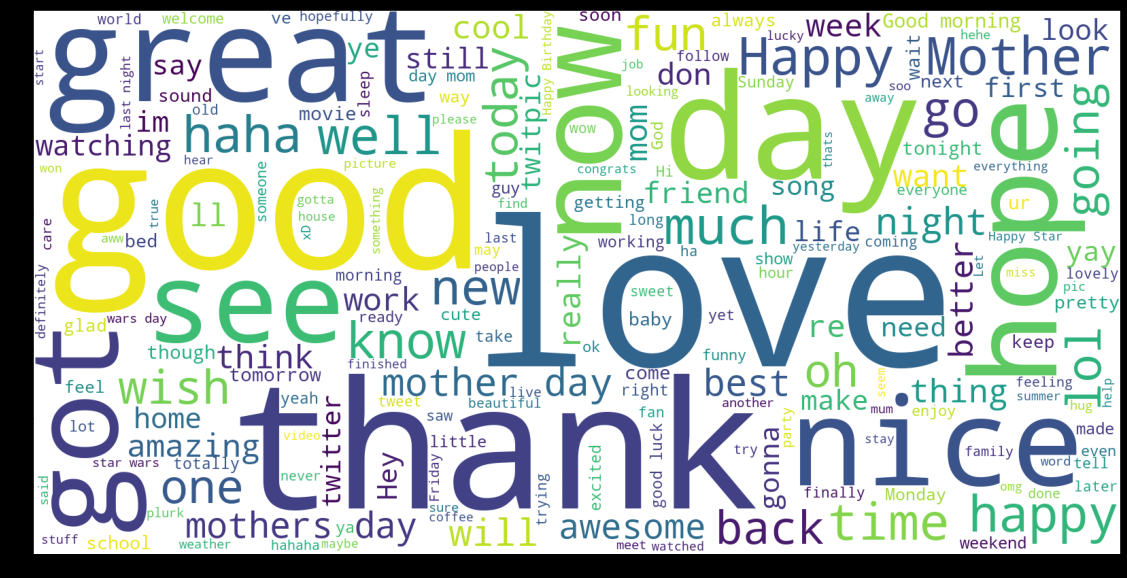

In [12]:
Positive = test[test['sentiment'] == ('positive')]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(Positive.text))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)
print(len(Negative))

We will see which words have the neutral sentiment

1001


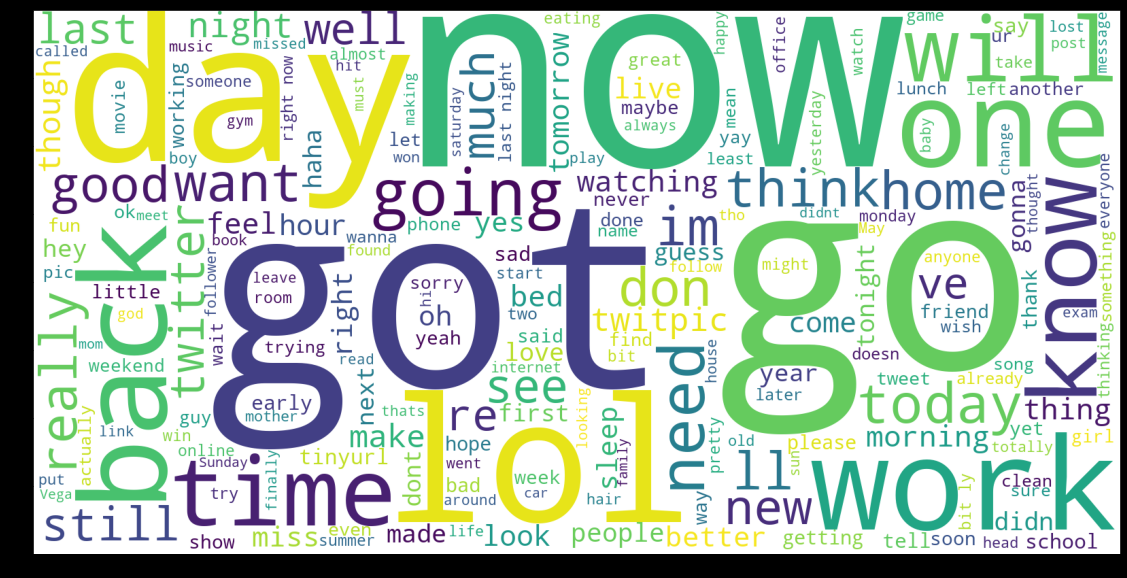

In [13]:
Neutral = test[test['sentiment'] == ('neutral')]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(Neutral.text))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)
print(len(Negative))

## **4.4/ Build roBERTa model**


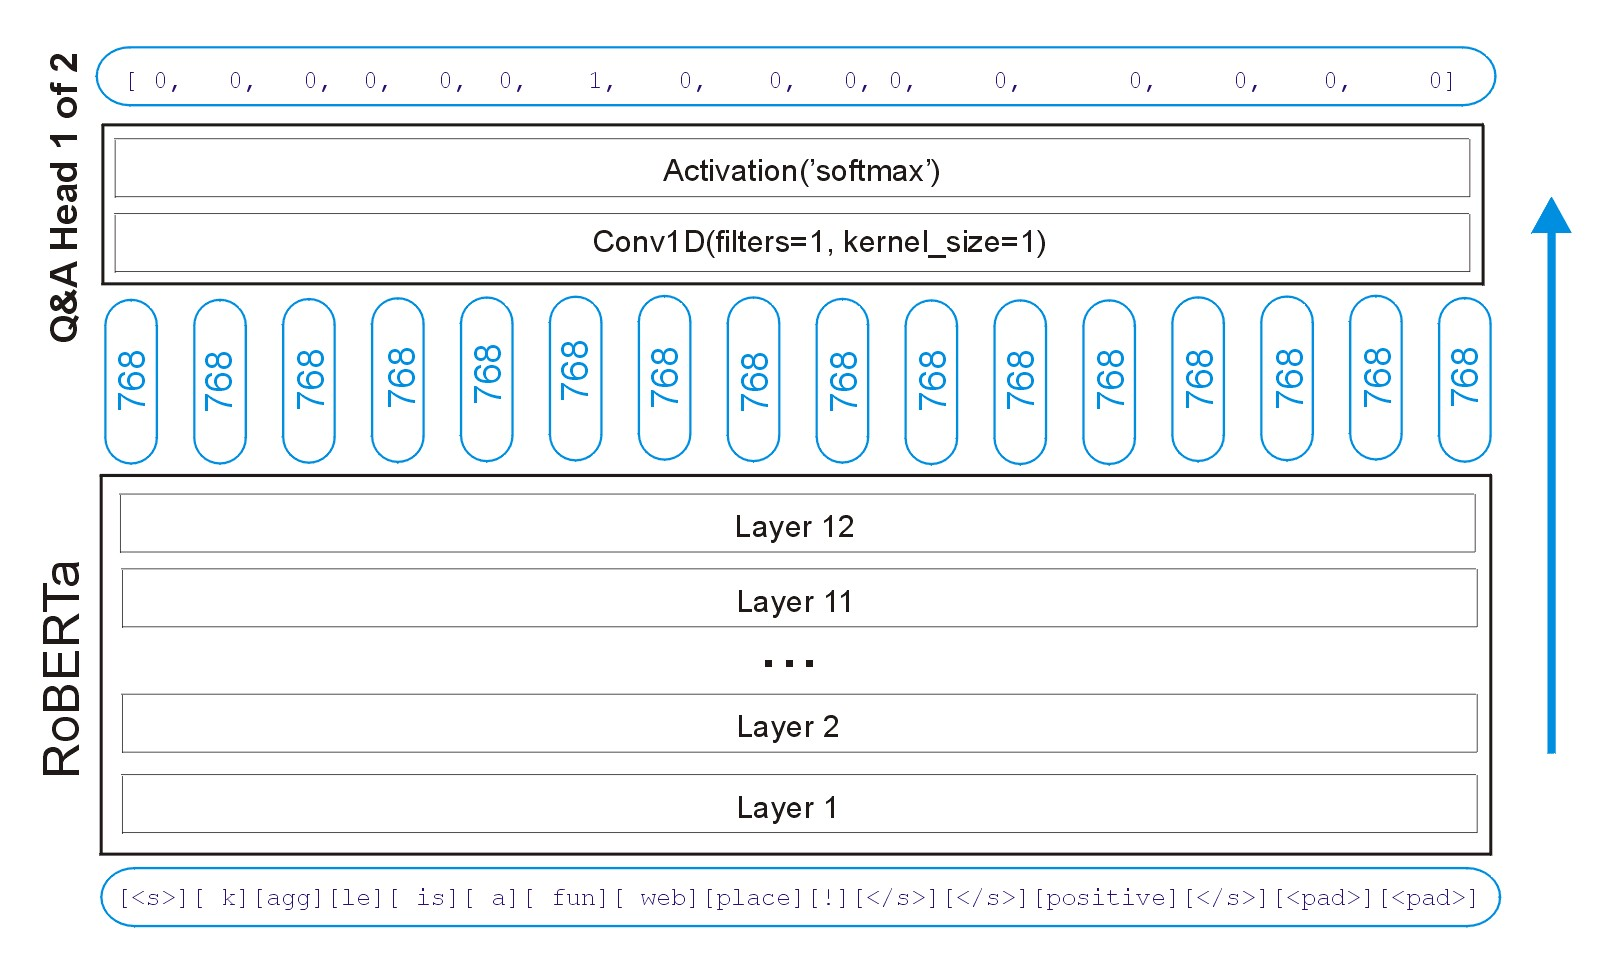

### **4.4.1/ Building the bones of model**
Built the bones of a roBERTa model, using the model has already train by the author.

In [14]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

## **4.5/ Create metric**


We code this for the evaluation

In [15]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

## **4.6/ Train roBERTa model**

In [16]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')
        
    model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[sv],
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print('Loading model...')
    model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

#########################
### FOLD 1
#########################
Train on 21984 samples, validate on 5497 samples
Epoch 1/3
21952/21984 [============================>.] - ETA: 0s - loss: 2.1666 - activation_loss: 1.0866 - activation_1_loss: 1.0800
Epoch 00001: val_loss improved from inf to 1.68563, saving model to v0-roberta-0.h5
21984/21984 [==============================] - 295s 13ms/sample - loss: 2.1662 - activation_loss: 1.0865 - activation_1_loss: 1.0796 - val_loss: 1.6856 - val_activation_loss: 0.8791 - val_activation_1_loss: 0.8064
Epoch 2/3
21952/21984 [============================>.] - ETA: 0s - loss: 1.6167 - activation_loss: 0.8282 - activation_1_loss: 0.7885
Epoch 00002: val_loss improved from 1.68563 to 1.65950, saving model to v0-roberta-0.h5
21984/21984 [==============================] - 279s 13ms/sample - loss: 1.6167 - activation_loss: 0.8283 - activation_1_loss: 0.7884 - val_loss: 1.6595 - val_activation_loss: 0.8580 - val_activation_1_loss: 0.8013
Epoch 3/3
21952/2198

## **4.7/ Kaggle submission**

In [17]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

In [18]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(30)

,textID,text,sentiment,selected_text
1253,b09213d54b,no. my school will start on June1. two days to go. i s...,negative,i still don`t want.
1529,d4305524e2,Weird! Maybe all the updates just aren`t being sent to ...,negative,weird!
3221,afe5ce5d7d,"Going to group therapy session, can`t wait to spill my g...",neutral,"going to group therapy session, can`t wait to spill my ..."
2787,0aec5ff9a0,is *ugh* what a miserable looking day. 54 degrees. Where...,negative,miserable
2808,449d73bf4f,"you tell yo mamma an em i axe how she durrin, and that i...",positive,happy
869,4c5a7e6ffc,I mean someone hit a dog with a car. It was just laying...,neutral,i mean someone hit a dog with a car. it was just laying...
387,d72edc0bb2,No TV and no internet make Catherine something something?,neutral,no tv and no internet make catherine something something?
2888,51ddb4abcf,Excitement: 8 new followers overnight. Sadness: 6 of the...,negative,sadness:
1668,4e43ad756c,Aw it says the pic doesn`t exist anymore,negative,aw it says the pic doesn`t exist anymore
704,6c843b2f56,i dunno if he saw it happy birthday girl!,positive,happy birthday girl!


### **4.7.1/ Results**

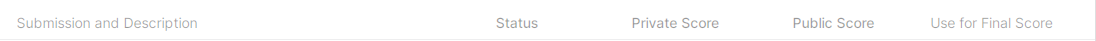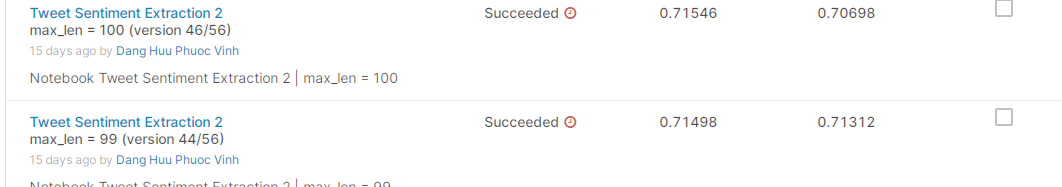